In [1]:
import datetime
from datetime import timedelta
import pandas as pd

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
from tqdm import tqdm_notebook
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

Using TensorFlow backend.


In [8]:
import urllib as u
from bs4 import BeautifulSoup as bs

In [33]:
#from pandas import Series
import statsmodels.api as sm
import itertools

# Data Acquisition:
- Scrapping using BS4

In [9]:
def getData(ticker):
    try:
        url = r'https://finance.yahoo.com/quote/{}/history?period1=1388559600&period2=1548918000&interval=1d&filter=history&frequency=1d'.format(ticker.lower())
        html = u.request.urlopen(url).read()
        soup = bs(html) # lxml but not neccessary

        df_dict = {} # put date & adj. close into a dictionary
        
        # iterate over trs and tags for date & adj. close span values
        thing = soup.find_all("tr")
        for t in thing:
            sub = t.find_all("span")
            try:
                date = datetime.datetime.strptime(sub[0].text, "%b %d, %Y")
                df_dict[date] = float(sub[5].text)
            except:
                continue

        data = pd.DataFrame.from_dict(df_dict, orient='index').rename(columns={0:ticker})
        return data
    except Exception as e:
        print(e)

In [5]:
tickers = ['TWTR', 'HAS', 'EIDX', 'KSS', 'GES']

In [10]:
# store all dfs in a dict
dfs = {}
for t in tickers:
    dfs[t] = getData(t)
    print("Finished getting data.\nData for {} has {} rows.\nFrom {} to {}".format(t, dfs[t].shape[0], 
                                                                                   min(dfs[t].index),
                                                                                   max(dfs[t].index)))

# Data Prep

In [22]:
def dataPrep(ticker = tickers[0] ):
    df_aapl = dfs[ticker]
    d1 = min(df_aapl.index)
    d2 = max(df_aapl.index)
    dates = [d1+timedelta(i) for i in range((d2 - d1).days)]
    dailys = pd.DataFrame(dates).rename(columns = {0:'date'})
    df_aapl = df_aapl.reset_index().rename(columns={'index':'date'})
    df_aapl = dailys.merge(df_aapl, how="left").set_index('date')
    df_aapl.ffill(inplace=True)
    # create freq indicator for index
    df_aapl.index = pd.DatetimeIndex(df_aapl.index.values,
                                   freq=df_aapl.index.inferred_freq)
    print("Finished prepping data.\nThere are {} rows of data.".format(df_aapl.shape[0]))
    return df_aapl

In [23]:
df_twtr = dataPrep()

Finished prepping data.
There are 146 rows of data.


In [30]:
df_aapl = df_twtr.copy()

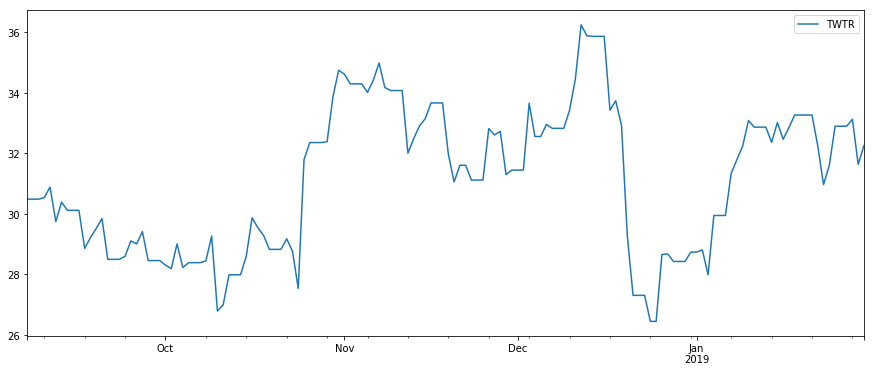

In [28]:
df_twtr.plot(figsize=(15, 6))

# Modeling

### - Decomposition

In [29]:
freq_step = 24*7

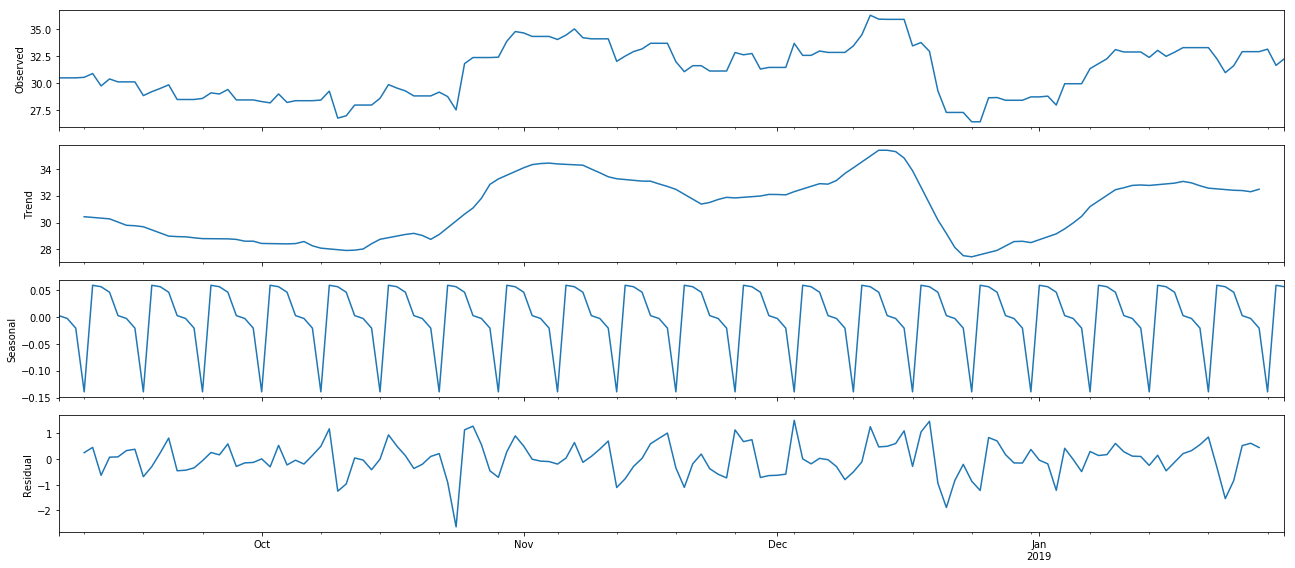

In [34]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_aapl, model='additive') # freq=freq_step
fig = decomposition.plot()
plt.show()

### - SARIMA

1. Get best params

In [41]:
def pickBestParams(df_aapl):
    """
    """
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    grid_result = dict()

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(df_aapl,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
                grid_result[param, param_seasonal] = results.aic
            except:
                continue

    for k, v in grid_result.items():
        if v == min(grid_result.values()):
            best = k

    return best

In [ ]:
best = pickBestParams(df_aapl)

2. Build model

In [42]:
mod = sm.tsa.statespace.SARIMAX(df_aapl,
                                order=best[0],
                                seasonal_order=best[1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8371      0.131     -6.384      0.000      -1.094      -0.580
ma.L1          1.0620      0.151      7.047      0.000       0.767       1.357
ma.S.L12      -1.0000    932.929     -0.001      0.999   -1829.506    1827.506
sigma2         0.7385    688.917      0.001      0.999   -1349.513    1350.990


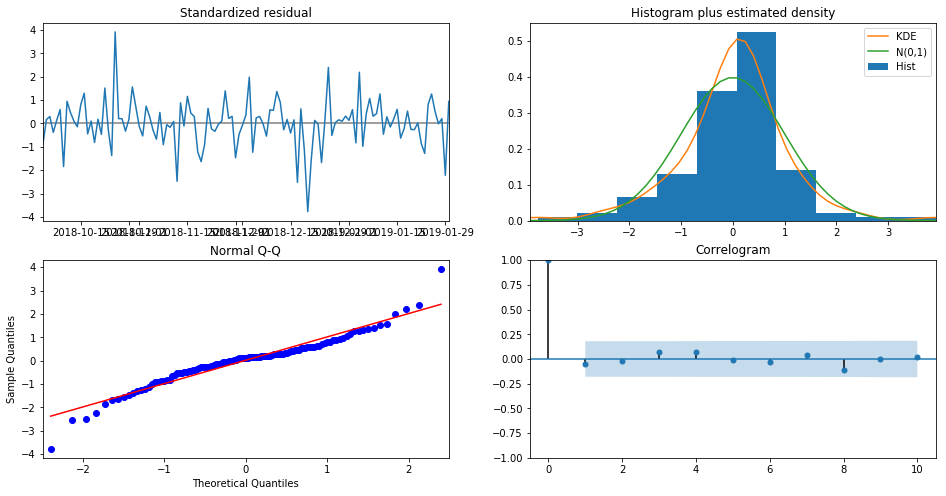

In [43]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

> **Need to log transform?**

3. Validate model

In [44]:
min(df_aapl.index)

Timestamp('2018-09-07 00:00:00', freq='D')

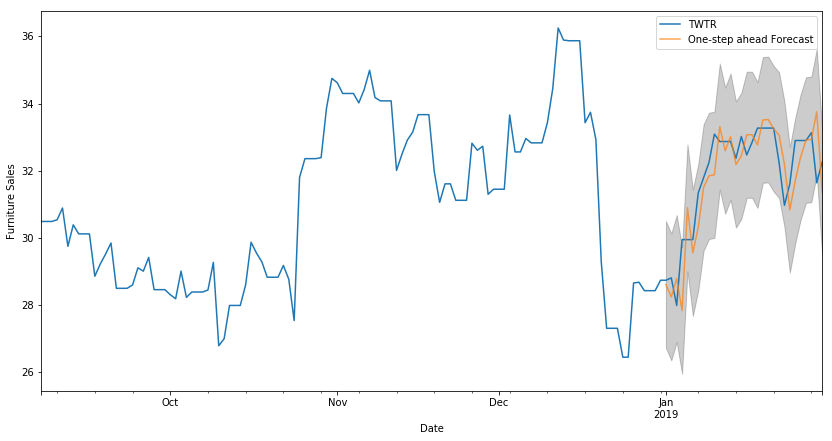

In [45]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_aapl['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [46]:
y_forecasted = pred.predicted_mean
y_truth = df_aapl['2019-01-01':][tickers[0]]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.68


4. Forecasting

/anaconda3/envs/money/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


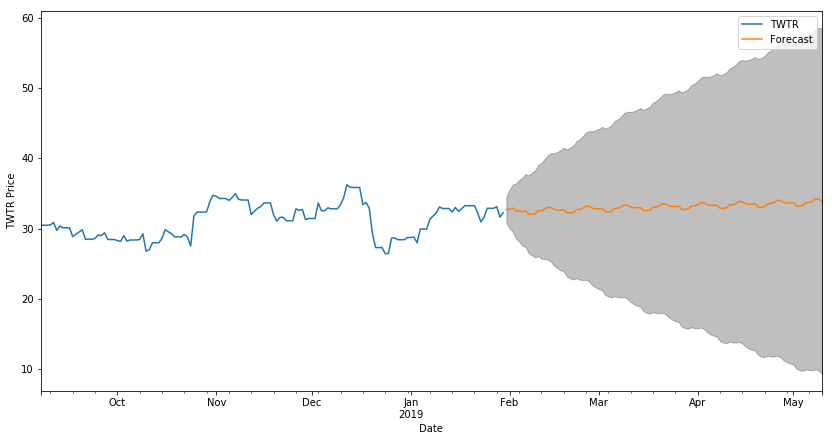

In [47]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = df_aapl.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('{} Price'.format(tickers[0]))
plt.legend()
plt.show()

5. Test model on another ticker

In [48]:
df_amzn = dataPrep(ticker=tickers[1])

Finished prepping data.
There are 142 rows of data.


In [49]:
best = pickBestParams(df_amzn)

/anaconda3/envs/money/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/anaconda3/envs/money/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [50]:
best

((1, 1, 1), (0, 1, 1, 12))

In [51]:
mod = sm.tsa.statespace.SARIMAX(df_amzn,
                                order=best[0],
                                seasonal_order=best[1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7649      0.202     -3.783      0.000      -1.161      -0.369
ma.L1          1.1296      0.192      5.880      0.000       0.753       1.506
ma.S.L12      -1.0000   8326.338     -0.000      1.000   -1.63e+04    1.63e+04
sigma2         1.3867   1.15e+04      0.000      1.000   -2.26e+04    2.26e+04


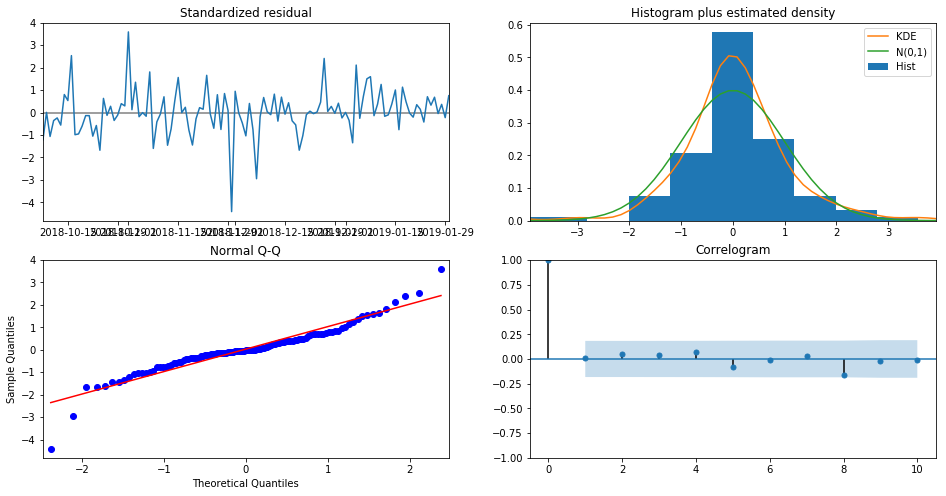

In [52]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

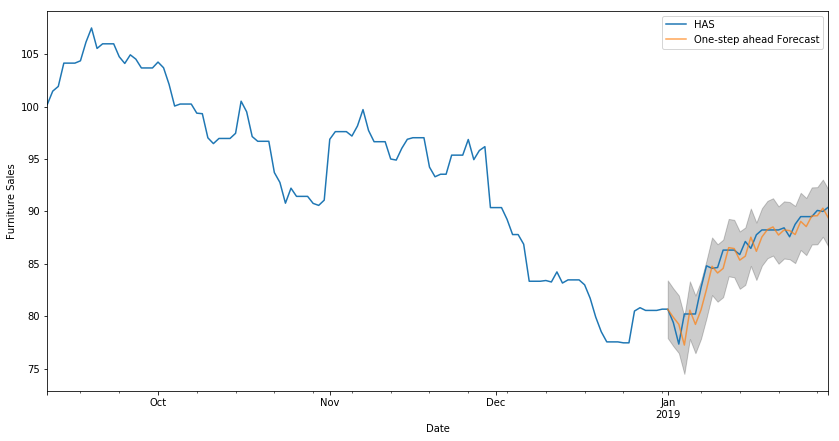

In [54]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_amzn['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

/anaconda3/envs/money/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


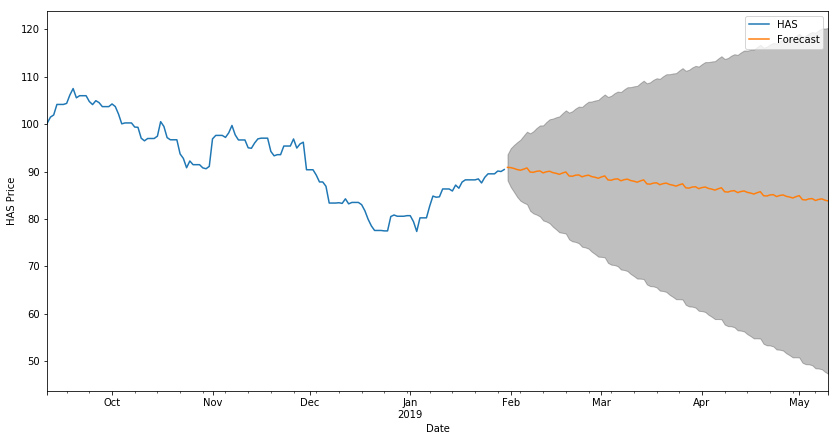

In [55]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = df_amzn.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('{} Price'.format(tickers[1]))
plt.legend()
plt.show()

# TBC: LSTM